In [32]:
# dependencies
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import pandas as pd
import keras_tuner
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [33]:
file_path = "datasets/pokemon.csv"
df = pd.read_csv(file_path)

In [ ]:
df = df.dropna(subset=["Type1"])
df = df[["Name", "Type1"]]

min_count = 27
class_counts = df["Type1"].value_counts()
df = df[df["Type1"].isin(class_counts[class_counts >= min_count].index)]

df["Type1_encoded"], type1_labels = pd.factorize(df["Type1"])
df["Type1_encoded"] = df["Type1_encoded"].astype(np.int32)

print(df["Type1"].value_counts())


train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)
train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 42)

Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Ghost        27
Dragon       27
Name: count, dtype: int64


In [35]:
# prepare the data
IMG_DIR = "images/pokemon_images"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

def fetch_images(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3) # since every pixel has values [0, 255], dividing by 255 normalizes them to [0, 1]
    img = tf.image.resize(img, IMG_SIZE ) / 255.0

    return tf.cast(img, tf.float32), tf.cast(label, tf.int32)

def tf_fetch_image(url, label):

    img, lbl = tf.py_function(fetch_images, [url, label], [tf.float32, tf.int32])
    img.set_shape((*IMG_SIZE, 3))
    lbl.set_shape(())

    return img, lbl

def make_datasets(sub_dataframe):
    paths = [os.path.join(IMG_DIR, f"{name}.png") for name in sub_dataframe["Name"]]

    ds = tf.data.Dataset.from_tensor_slices((paths, sub_dataframe["Type1_encoded"].values))
    ds = ds.map(tf_fetch_image, num_parallel_calls = tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds, val_ds, test_ds = make_datasets(train_df), make_datasets(val_df), make_datasets(test_df)

(32, 128, 128, 3) tf.Tensor(
[ 3  2  0 10  2  6  9  2  6  4  4  2  0 11  6  0  2  4  8  9  2  1  1  9
  4 10  4  2  6  0  0  0], shape=(32,), dtype=int32)


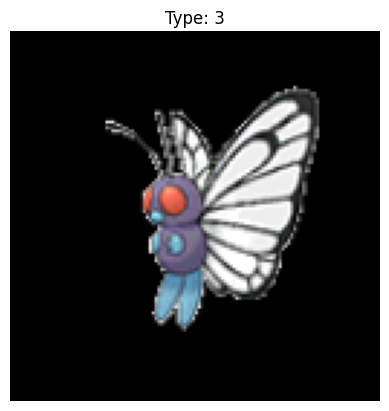

In [36]:
# here we can visualize the data (optional)

"""
the first for loop displays:

(32, 224, 224, 3) [3.3, ...., 1.5]

Here we have:
- a batch of 32 images
- 224x224 each (and their 3 respetive channels)
- [ints] the array of brands for each image
"""

for img, lbl in train_ds.take(1):
    print(img.shape, lbl)

"""
second for loop shows the image
"""
for imgs, labels in train_ds.take(1):
    plt.imshow(imgs[0])        # show first image in the batch
    plt.title(f"Type: {labels[0].numpy()}")
    plt.axis("off")
    plt.show()


In [37]:
def build_cnn_model(hp):
    num_classes = 14
    model = tf.keras.Sequential()

    # input layer
    model.add(tf.keras.layers.Input(shape = (128, 128, 3)))

    # convolutional layers
    for i in range(hp.Int("num_conv_layers", 2, 4)):
        model.add(tf.keras.layers.Conv2D(
            filters = hp.Int(f"filters_{i}", min_value = 32, max_value = 128, step = 32),
            kernel_size = hp.Choice("kernel_size", values = [3]),
            activation = "relu",
            padding = "same"
        ))
        model.add(tf.keras.layers.Dropout(
        rate=hp.Float(f"dropout_conv_{i}", min_value=0.1, max_value=0.4, step=0.1)
            ))
        model.add(tf.keras.layers.MaxPooling2D(pool_size = 2))


    # global average pooling to connect with dense layers
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # dense layers
    for j in range(hp.Int("num_dense_layers", 1, 2)):
        model.add(tf.keras.layers.Dense(
            units = hp.Int(f"units_dense_{j}", min_value = 64, max_value = 128, step = 64),
            activation = hp.Choice("activation", ["relu"])
        ))

    # dropout after dense layers
    model.add(tf.keras.layers.Dropout(
        rate=hp.Float(f"dropout_dense_{j}", min_value=0.2, max_value=0.5, step=0.1)
    ))

    # output layer for classification
    model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

    # hyperparameter: learning rate
    hp_lr = hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])

    # compile for classification
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = hp_lr),
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )

    return model

In [38]:
build_cnn_model(keras_tuner.HyperParameters())

<Sequential name=sequential_1, built=True>

In [39]:
tuner = keras_tuner.RandomSearch(
    hypermodel = build_cnn_model,
    objective = "val_accuracy",
    max_trials = 10,
    directory = "my_dir",
    project_name = "cnn_classification_tunning",
    overwrite = True
)

tuner.search_space_summary()

Search space summary
Default search space size: 11
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3], 'ordered': True}
dropout_conv_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_conv_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 64, 'sampling': '

In [40]:
tuner.search(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
)

Trial 10 Complete [00h 00m 46s]
val_accuracy: 0.23529411852359772

Best val_accuracy So Far: 0.2689075767993927
Total elapsed time: 00h 22m 18s


In [41]:
tuner.results_summary()

Results summary
Results in my_dir\cnn_classification_tunning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
num_conv_layers: 2
filters_0: 128
kernel_size: 3
dropout_conv_0: 0.4
filters_1: 96
dropout_conv_1: 0.1
num_dense_layers: 2
units_dense_0: 64
activation: relu
dropout_dense_0: 0.30000000000000004
learning_rate: 0.01
units_dense_1: 64
dropout_dense_1: 0.2
Score: 0.2689075767993927

Trial 04 summary
Hyperparameters:
num_conv_layers: 3
filters_0: 64
kernel_size: 3
dropout_conv_0: 0.30000000000000004
filters_1: 64
dropout_conv_1: 0.30000000000000004
num_dense_layers: 2
units_dense_0: 64
activation: relu
dropout_dense_0: 0.30000000000000004
learning_rate: 0.001
units_dense_1: 64
dropout_dense_1: 0.2
filters_2: 32
dropout_conv_2: 0.2
filters_3: 96
dropout_conv_3: 0.1
Score: 0.2689075767993927

Trial 02 summary
Hyperparameters:
num_conv_layers: 2
filters_0: 128
kernel_size: 3
dropout_conv_0: 0.2
filters_1: 32
dropout_conv_1: 0.4


In [42]:
# extract the best model
best_model = tuner.get_best_models(num_models = 1)[0]
best_model.summary()

d:\My Stuff\Python\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 96)     │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,550 (490.43 KB)

 Trainable params: 125,550 (490.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1992 - loss: 2.4639 - val_accuracy: 0.2269 - val_loss: 2.5119
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1970 - loss: 2.4386 - val_accuracy: 0.2689 - val_loss: 2.5038
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1928 - loss: 2.4151 - val_accuracy: 0.2689 - val_loss: 2.5081
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1758 - loss: 2.4189 - val_accuracy: 0.2773 - val_loss: 2.5037
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1970 - loss: 2.4041 - val_accuracy: 0.2689 - val_loss: 2.5117
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2034 - loss: 2.4096 - val_accuracy: 0.2689 - val_loss: 2.5063
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1928 - loss: 2.4067 - val_accuracy: 0.2605 - val_loss: 2.5230
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1907 - loss: 2.3970 - val_accuracy: 0.2269 - val_loss:

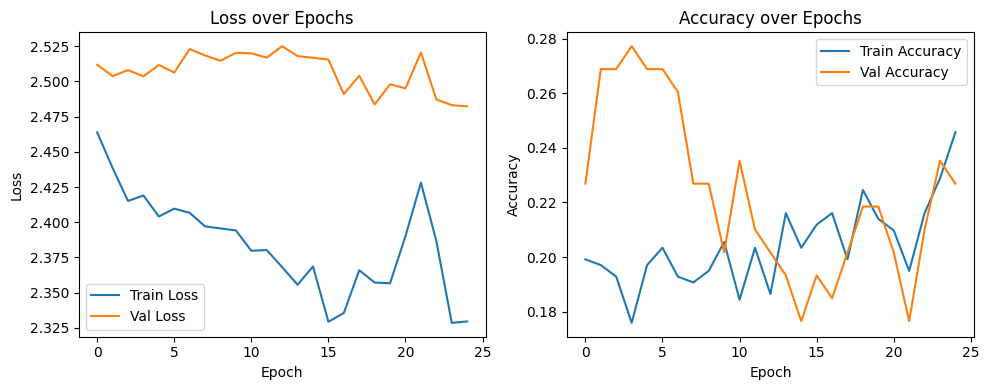

In [43]:
history = best_model.fit(train_ds, validation_data=val_ds, epochs=25)

# then later:
plt.figure(figsize=(10, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


d:\My Stuff\Python\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\My Stuff\Python\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\My Stuff\Python\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0       0.04      0.05      0.05        19
           1       0.29      0.33      0.31         6
           2       0.30      0.54      0.38        26
           3       1.00      0.08      0.14        13
           4       0.24      0.80      0.36        20
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         4

    accuracy                           0.23       148
   macro avg       0.13      0.13      0.09       148
weighted avg       0.19      0.23      0.15       148



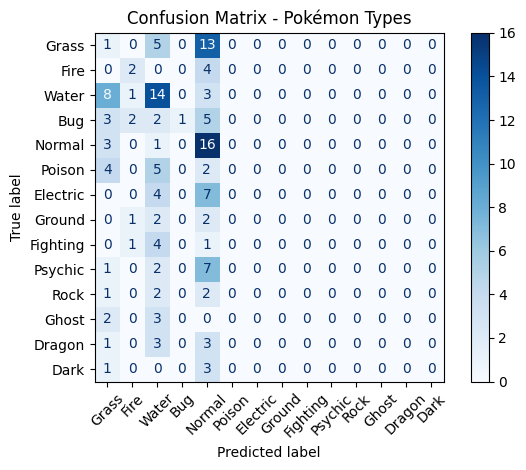

In [44]:
# metrics
y_true = np.concatenate([y for x, y in test_ds], axis = 0)
y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print(classification_report(y_true, y_pred))


# confusion matrix 

class_names = df["Type1"].unique()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Pokémon Types")
plt.tight_layout()
plt.show()


In [ ]:
# the dataset has literal no data to work with, so the model will mostly fail. (After data preprocessing, we are left with 739 images).